In [39]:
from aicsimageio import AICSImage
import stackview
import skimage
from skimage.measure import label
from skimage.segmentation import clear_border
import numpy as np
from cellpose import models
import pandas as pd
import matplotlib.pyplot as plt
import roifile

In [75]:
data_name = "Test2"
file_path = "Z:\\Kunal\\" + data_name + "\\" + data_name + "_MMStack_Pos0.ome.tif"
roi_path = "Z:\\Kunal\\" + data_name + "RoiSet.zip"

In [97]:
img = AICSImage(file_path)
metadata = img.metadata
delta_t = metadata.images[0].pixels.time_increment
delta_x = metadata.images[0].pixels.physical_size_x
delta_y = metadata.images[0].pixels.physical_size_y

In [77]:
# data is returned as a 5d array in the shape t, c, z, x, y.  Since we do not have c or z, remove them here cheaply
img_data = np.squeeze(img.data, axis=(1, 2))
stackview.slice(img_data, slice_number=200, zoom_factor=0.3, continuous_update=False)

In [78]:
mean_projection = np.mean(img_data, axis=0)
stackview.slice(mean_projection, zoom_factor=0.3, continuous_update=False)

In [79]:
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import expand_labels, watershed

edges = sobel(mean_projection)
# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(edges)
foreground, background = 1, 2
markers[mean_projection < 125.0] = background
markers[mean_projection > 150.0] = foreground

edgesint32 = edges.astype(np.int32)
ws = watershed(edges.astype(np.int32), markers.astype(np.int32))
seg1 = label(ws == foreground)

stackview.slice(seg1, zoom_factor=0.3)

In [80]:
model = models.CellposeModel(gpu=True)
masks, flows, styles = model.eval(mean_projection, diameter=50)

In [81]:
labels = label(masks)
labels = clear_border(labels) 
stackview.curtain(mean_projection, labels, continuous_update=True, zoom_factor=0.3)

In [98]:
props = skimage.measure.regionprops_table(
    masks.astype(np.uint8),
    intensity_image=img_data[0],
    properties=('label', 'area', 'intensity_mean'),
)
# filter out nuclei smaller than 1000 pixels
df = pd.DataFrame.from_dict(props)
df = df[df['area'] > 1000]
print("Number of cells: " + str(df.size))
print("Average area (um2): " + str(df['area'].mean() * delta_x * delta_y))

Number of cells: 126
Average area (um2): 269.90816507809524


In [83]:
tables = [
    skimage.measure.regionprops_table(masks.astype(np.uint8), image, properties=('label', 'intensity_mean') ) for image in img_data
]

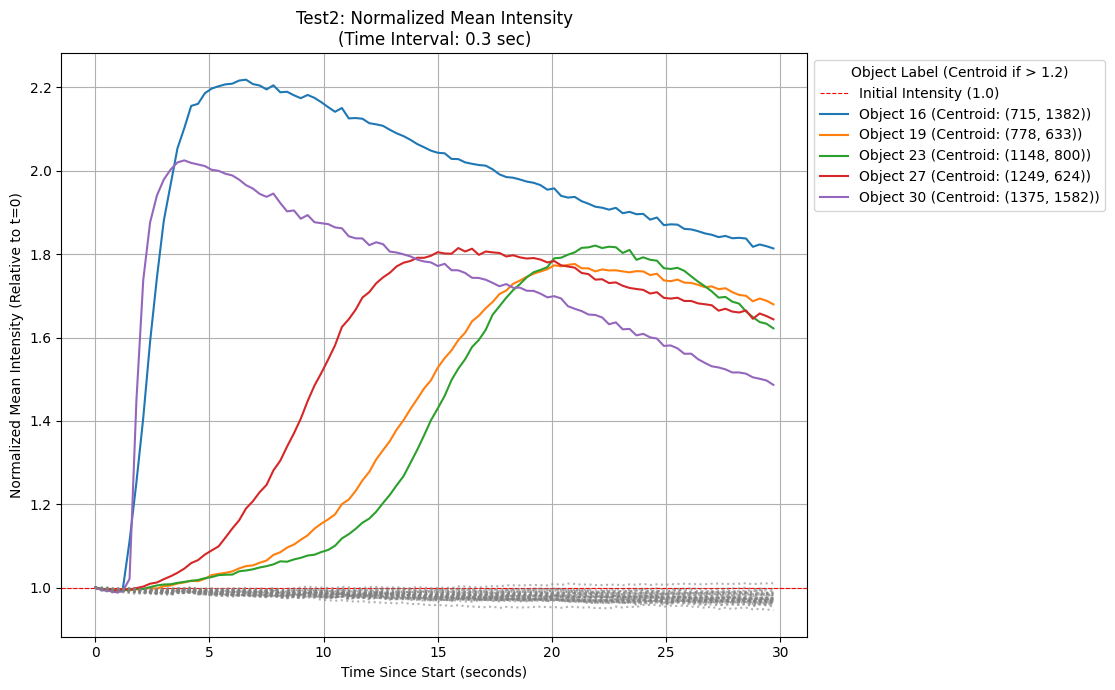

In [84]:
# --- User-definable parameters ---
time_interval_seconds = delta_t / 1000  # Read from Image metadata
normalization_threshold = 1.2 # Normalized Mean Intensity threshold for legend display


# --- 2. Generate region properties tables for all time points ---
tables = [
    skimage.measure.regionprops_table(masks.astype(np.uint8), image, properties=('label', 'intensity_mean'))
    for image in img_data
]

# --- 3. Consolidate data into a single Pandas DataFrame and add time in seconds ---
df_list = []
for t, table in enumerate(tables):
    df = pd.DataFrame(table)
    df['time_point'] = t  # Keep original time point for reference if needed
    df['time_seconds'] = t * time_interval_seconds # Calculate time in seconds
    df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)

# --- 4. Normalize 'intensity_mean' for each object based on its first time point ---

# Get unique labels (objects) from the mask
unique_labels = np.unique(masks[masks != 0]) # Exclude background label (0)

# Create a new column for normalized intensity
full_df['intensity_mean_normalized'] = np.nan # Initialize with NaN

for label in unique_labels:
    label_df = full_df[full_df['label'] == label].copy()

    first_intensity = label_df.sort_values(by='time_seconds').iloc[0]['intensity_mean']

    if first_intensity != 0:
        normalized_values = label_df['intensity_mean'] / first_intensity
    else:
        normalized_values = np.zeros_like(label_df['intensity_mean'])

    full_df.loc[full_df['label'] == label, 'intensity_mean_normalized'] = normalized_values

# --- 5. Calculate Centroids for each object ---
properties = skimage.measure.regionprops(masks.astype(np.uint8))
centroids = {}
for prop in properties:
    centroids[prop.label] = prop.centroid # Centroid is (row, col)

# --- 6. Plot normalized 'intensity_mean' for each object over time ---

plt.figure(figsize=(15, 7)) # Adjust figure size as needed

# Plot the reference line first, so it's at the bottom of the legend
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=0.8, label='Initial Intensity (1.0)')

pos_masks = np.zeros_like(masks)

for label in unique_labels:
    # Filter data for the current label
    label_df = full_df[full_df['label'] == label]

    # Check if the normalized intensity exceeds the threshold at any point for this object
    exceeds_threshold = (label_df['intensity_mean_normalized'] > normalization_threshold).any()

    # Get centroid for the current label
    centroid_coords = centroids.get(label, (np.nan, np.nan))
    centroid_str = f'({centroid_coords[0]:.0f}, {centroid_coords[1]:.0f})'

    # Conditionally add the 'label' argument to plt.plot()
    if exceeds_threshold:
        # Only provide a label if the threshold is met
        plt.plot(label_df['time_seconds'], label_df['intensity_mean_normalized'],
                 label=f'Object {label} (Centroid: {centroid_str})')
        pos_masks[masks == label] = label
    else:
        # Do not provide a label for objects that don't meet the threshold
        plt.plot(label_df['time_seconds'], label_df['intensity_mean_normalized'],
                 color='gray', linestyle=':', alpha=0.6) # Optionally, plot them differently

plt.xlabel('Time Since Start (seconds)')
plt.ylabel('Normalized Mean Intensity (Relative to t=0)')
plt.title(data_name + f': Normalized Mean Intensity\n(Time Interval: {time_interval_seconds} sec)')
plt.grid(True)


# The legend will now automatically only include those lines for which a 'label' was provided
plt.legend(title=f'Object Label (Centroid if > {normalization_threshold})', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.show()

In [85]:
import roifile
import numpy as np
import pandas as pd
import os

def read_imagej_rois(file_path):
    """
    Reads ImageJ ROI files (.roi or .zip) and extracts ROI information,
    including x, y coordinates.

    Args:
        file_path (str): The path to the ImageJ ROI file (e.g., 'my_rois.roi'
                         or 'my_rois.zip').

    Returns:
        list of dict: A list where each dictionary represents an ROI.
                      Each dictionary contains at least 'label' and 'coordinates'.
                      The structure of 'coordinates' depends on the ROI type.
                      Returns an empty list if no ROIs are found or file is invalid.
    """
    roi_data = []

    try:
        # roifile.ImagejRoi.fromfile() is the correct method for reading a single .roi file.
        # For .zip files, it correctly detects and returns a list of ROI objects.
        # This simplifies the initial reading step significantly.
        rois = roifile.ImagejRoi.fromfile(file_path)

        # Ensure 'rois' is always a list for consistent processing
        if not isinstance(rois, list):
            rois = [rois] # Wrap single ROI object in a list

        for roi_obj in rois:
            coords = get_roi_coordinates(roi_obj)
            if coords is not None:
                # Use roi_obj.name for label, fallback if name is not explicitly set
                label = roi_obj.name if roi_obj.name else f"ROI_{rois.index(roi_obj) + 1}"
                # If it's a single .roi file and no name, use filename without extension
                if not roi_obj.name and len(rois) == 1:
                    label = os.path.basename(file_path).replace('.roi', '')

                roi_data.append({
                    'label': label,
                    'roi_type': roi_obj.roitype.name, # Use .name for string representation
                    'coordinates': coords
                })

    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
        return []

    return roi_data

def get_roi_coordinates(roi_obj):
    """
    Extracts coordinates from a roifile.ImagejRoi object based on its type.

    Args:
        roi_obj (roifile.ImagejRoi): An ROI object read by roifile.

    Returns:
        numpy.ndarray or None: A NumPy array of (x, y) coordinates for polygon,
                               freehand, line, or point ROIs.
                               For rectangular or oval ROIs, it returns the bounding box.
                               Returns None for unsupported ROI types or if coordinates are not applicable.
    """
    roi_type = roi_obj.roitype

    if roi_type in [roifile.ROI_TYPE.POLYGON, 
                    roifile.ROI_TYPE.FREELINE, roifile.ROI_TYPE.POINT]:
        # For polygon, freehand, freehandline, and point, the 'points' attribute contains vertices
        # Or, the roi_obj itself can be iterated if it's a point ROI.
        # The coordinates() method is generally the way to get geometric points.
        return roi_obj.coordinates()
    elif roi_type in [roifile.ROI_TYPE.RECT, roifile.ROI_TYPE.OVAL]:
        # Rectangular/Oval ROI: defined by bounding box [left, top, right, bottom]
        # Coordinates can be represented as top-left and bottom-right corners
        return np.array([[roi_obj.left, roi_obj.top],
                         [roi_obj.right, roi_obj.bottom]])
    elif roi_type == roifile.ROI_TYPE.LINE:
        # Line ROI: x1, y1, x2, y2
        return np.array([[roi_obj.x1, roi_obj.y1],
                         [roi_obj.x2, roi_obj.y2]])
    else:
        print(f"Warning: ROI type '{roi_type.name}' ({roi_type}) not explicitly handled for coordinate extraction. "
              "Check roifile documentation for how to access its specific data. ROI Label: {roi_obj.name}")
        return None
        
rois = read_imagej_rois(roi_path)

In [86]:
coordinates = []
for roi in rois:
    coordinates.append((int(roi['coordinates'][0][0]), int(roi['coordinates'][0][1])))
print (coordinates)

[(594, 1300), (988, 1122), (1394, 710), (1582, 1376), (790, 1632), (828, 1166), (624, 784)]


In [87]:
from typing import List, Tuple, Union

def create_x_marker_image(coordinates: List[Tuple[int, int]], 
                         image_shape: Tuple[int, int] = (512, 512),
                         x_size: int = 5,
                         marker_value: Union[int, float] = 255,
                         background_value: Union[int, float] = 0) -> np.ndarray:
    """
    Creates an image with X markers at specified coordinates.
    
    Parameters:
    -----------
    coordinates : List[Tuple[int, int]]
        List of (x, y) coordinates where X markers should be placed
    image_shape : Tuple[int, int], optional
        Shape of the output image as (height, width). Default: (512, 512)
    x_size : int, optional
        Size of the X marker (radius from center). Default: 5
    marker_value : Union[int, float], optional
        Value to use for the X marker pixels. Default: 255
    background_value : Union[int, float], optional
        Value to use for the background pixels. Default: 0
    
    Returns:
    --------
    np.ndarray
        2D numpy array representing the image with X markers
    """
    # Create the background image
    image = np.full(image_shape, background_value, dtype=np.float32)
    
    height, width = image_shape
    
    # Draw X at each coordinate
    for x, y in coordinates:
        # Skip coordinates outside image bounds
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
            
        # Draw the X marker
        draw_x_marker(image, x, y, x_size, marker_value, height, width)
    
    return image

def draw_x_marker(image: np.ndarray, 
                  center_x: int, 
                  center_y: int, 
                  size: int,
                  value: Union[int, float],
                  height: int, 
                  width: int) -> None:
    """
    Draws an X marker on the image at the specified center point.
    
    Parameters:
    -----------
    image : np.ndarray
        The image array to draw on
    center_x, center_y : int
        Center coordinates of the X marker
    size : int
        Size (radius) of the X marker
    value : Union[int, float]
        Value to use for the marker pixels
    height, width : int
        Dimensions of the image
    """
    # Draw diagonal lines for the X
    for i in range(-size, size + 1):
        # Main diagonal (top-left to bottom-right)
        x1, y1 = center_x + i, center_y + i
        if 0 <= x1 < width and 0 <= y1 < height:
            image[y1, x1] = value
        
        # Anti-diagonal (top-right to bottom-left)
        x2, y2 = center_x + i, center_y - i
        if 0 <= x2 < width and 0 <= y2 < height:
            image[y2, x2] = value

def create_thick_x_marker_image(coordinates: List[Tuple[int, int]], 
                               image_shape: Tuple[int, int] = (512, 512),
                               x_size: int = 5,
                               thickness: int = 1,
                               marker_value: Union[int, float] = 255,
                               background_value: Union[int, float] = 0) -> np.ndarray:
    """
    Creates an image with thick X markers at specified coordinates.
    
    Parameters:
    -----------
    coordinates : List[Tuple[int, int]]
        List of (x, y) coordinates where X markers should be placed
    image_shape : Tuple[int, int], optional
        Shape of the output image as (height, width). Default: (512, 512)
    x_size : int, optional
        Size of the X marker (radius from center). Default: 5
    thickness : int, optional
        Thickness of the X lines. Default: 1
    marker_value : Union[int, float], optional
        Value to use for the X marker pixels. Default: 255
    background_value : Union[int, float], optional
        Value to use for the background pixels. Default: 0
    
    Returns:
    --------
    np.ndarray
        2D numpy array representing the image with thick X markers
    """
    # Create the background image
    image = np.full(image_shape, background_value, dtype=np.int64)
    
    height, width = image_shape
    
    # Draw thick X at each coordinate
    for x, y in coordinates:
        # Skip coordinates outside image bounds
        if x < 0 or x >= width or y < 0 or y >= height:
            continue
            
        # Draw the thick X marker
        draw_thick_x_marker(image, x, y, x_size, thickness, marker_value, height, width)
    
    return image

def draw_thick_x_marker(image: np.ndarray, 
                       center_x: int, 
                       center_y: int, 
                       size: int,
                       thickness: int,
                       value: Union[int, float],
                       height: int, 
                       width: int) -> None:
    """
    Draws a thick X marker on the image at the specified center point.
    """
    # Draw thick diagonal lines for the X
    for i in range(-size, size + 1):
        for t in range(-thickness//2, thickness//2 + 1):
            # Main diagonal (top-left to bottom-right)
            x1, y1 = center_x + i, center_y + i + t
            if 0 <= x1 < width and 0 <= y1 < height:
                image[y1, x1] = value
            
            x1, y1 = center_x + i + t, center_y + i
            if 0 <= x1 < width and 0 <= y1 < height:
                image[y1, x1] = value
            
            # Anti-diagonal (top-right to bottom-left)
            x2, y2 = center_x + i, center_y - i + t
            if 0 <= x2 < width and 0 <= y2 < height:
                image[y2, x2] = value
                
            x2, y2 = center_x + i + t, center_y - i
            if 0 <= x2 < width and 0 <= y2 < height:
                image[y2, x2] = value

In [88]:
#Overlay the positive masks with time lapse and do alpha blending
pos_labels = skimage.measure.label(pos_masks)
roi_labels = create_thick_x_marker_image(coordinates, (2048, 2048), 50, 5, 2)
posroi_labels = pos_labels + roi_labels
posroi_labels = np.repeat(posroi_labels[np.newaxis, :, :], img_data.shape[0], axis=0)
stackview.blend(img_data, posroi_labels, continuous_update=True, zoom_factor=0.3)